[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# definições do azure
_set_env("OPENAI_API_KEY") 
os.environ["OPENAI_API_VERSION"] = "2024-12-01-preview"
os.environ["ENDPOINT"] = "https://cog-open-ai-lab.openai.azure.com/" 
os.environ["MODEL_DEPLOYMENT"] = "gpt-4o"
os.environ["MODEL_NAME"] = "gpt-4o"

# definições do langsmith
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

OPENAI_API_KEY:  ········
LANGSMITH_API_KEY:  ········


## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [5]:
from langchain_openai import AzureChatOpenAI
import os
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import MessagesState
from typing_extensions import Literal
from langgraph.graph import END

model = AzureChatOpenAI( 
    openai_api_version=os.getenv('OPENAI_API_VERSION'),
    azure_endpoint=os.getenv('ENDPOINT'),
    azure_deployment=os.getenv('MODEL_DEPLOYMENT'),                            
    model=os.getenv('MODEL_NAME'), 
    temperature=0
)

# definição do estado
class State(MessagesState):
    summary: str

# definição dos nós

def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages) 
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\\n\\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages) 
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Nó de Roteamento (Original, sem RAG)
def should_continue(state: State) -> Literal ["summarize_conversation", END]:
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

Now, we just re-compile with our sqlite checkpointer.

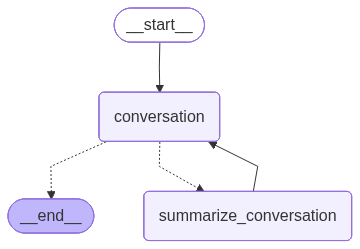

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import Literal 

# --- Grafo ---
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# 1. START
workflow.add_edge(START, "conversation")

# 2. condicional
workflow.add_conditional_edges("conversation", should_continue)

# 3. ciclo de sumarização
workflow.add_edge("summarize_conversation", "conversation") 

# compile com SQLite Checkpointer (a Célula 7, que define 'memory', deve ser executada antes)
graph = workflow.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm guilherme")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like to play cs2!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Guilherme! Great to meet you! What’s on your mind today? 😊
================================== Ai Message ==================================

Your name is Guilherme! 😊
================================== Ai Message ==================================

That's awesome! Counter-Strike 2 is such a fun and competitive game. Do you have a favorite map or weapon you like to use? Or maybe some epic plays you’ve pulled off recently? 😄


Let's confirm that our state is saved locally.

In [8]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='i like to play cs2!', additional_kwargs={}, response_metadata={}, id='a0966baf-e855-4deb-8bfb-400e2606198a'), AIMessage(content="That's awesome, Guilherme! Counter-Strike 2 is such a fun and competitive game. Do you have a favorite map or weapon you like to use? Or maybe some epic plays you’ve pulled off recently? 😄", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 277, 'total_tokens': 323, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CZ1UmDTnLqjMoYj6h177IMeeqyH3d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jail

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='i like to play cs2!', additional_kwargs={}, response_metadata={}, id='a0966baf-e855-4deb-8bfb-400e2606198a'), AIMessage(content="That's awesome, Guilherme! Counter-Strike 2 is such a fun and competitive game. Do you have a favorite map or weapon you like to use? Or maybe some epic plays you’ve pulled off recently? 😄", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 277, 'total_tokens': 323, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CZ1UmDTnLqjMoYj6h177IMeeqyH3d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jail

## Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.
Load the `chatbot` in Studio, which uses `module-2/studio/chatbot.py` set in `module-2/studio/langgraph.json`.